This will look into how changes in the initial population size for the genetic agorthem effect the number of generations until convergence. we will describe a series of sequences as "converged" if the best score over the set number of generations has reached a stable point. This stable point may not be the optimal point, we may have found a local maxima for the solution sequence rather than the global maximum.

In [1]:
%matplotlib inline
import os
import time
import axelrod as axl
import axelrod_dojo as axl_dojo
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

The opponents we select are intresting, they are all "simple" and can be esplained in a very brief sentence or two. we will look into these as we can confirm that the genetic algorith will select the optimal sequence solution for the selected oponent.

In [2]:
C, D = axl.Action
my_cycler_Seq = "CCCDDCCCDDDCD"
intresting_opponents = [axl.TitForTat(), axl.Alternator(), axl.Grudger(), axl.Random(), axl.EvolvedFSM16(), axl.CollectiveStrategy()] 
                        
# add me: axl.ZDExtortion()

For ease of data production, lets define a function that we can run a cycle of finding a solution with a set of parameters 

In [3]:
def runGeneticAlgo(opponent, population_size=150, number_of_game_turns=200, cycle_length=200, generations=250,
                   mutation_probability=0.1, mutation_potency=1, reset_file=True):
    cycler_class = axl_dojo.CyclerParams
    cycler_objective = axl_dojo.prepare_objective(name="score", turns=number_of_game_turns, repetitions=1)
    cycler_kwargs = {
        "sequence_length": cycle_length,
        "mutation_probability":mutation_probability,
        "mutation_potency":mutation_potency
    }

    output_file_name = "data/" + str(opponent).replace(" ","_") + ".csv"
    try:
        if reset_file and os.path.isfile(output_file_name):
            os.remove(output_file_name)
    finally:
        print(str(opponent), 
              "|| pop size:", population_size,
              "\tturns:", number_of_game_turns,
              "\tcycle len:", cycle_length,
              "\tgens:", generations,
              "\tmut. rate:",mutation_probability,
              "\t, potency:",mutation_potency)
        
        axl.seed(1)
            
        population = axl_dojo.Population(params_class=cycler_class,
                                         params_kwargs=cycler_kwargs,
                                         size=population_size,
                                         objective=cycler_objective,
                                         output_filename=output_file_name,
                                         opponents=[opponent],
                                         print_output=False)
        population.run(generations)
        print("\tAnalysis Complete:",output_file_name)
    # Store the file name and opponent name as a tuple
    return output_file_name, str(opponent)


In [4]:
run1 = runGeneticAlgo(axl.TitForTat(),population_size=20, number_of_game_turns=200, cycle_length=200, generations=300,
                   mutation_probability=0.1,mutation_potency=1,reset_file=True)

Tit For Tat || pop size: 20 	turns: 200 	cycle len: 200 	gens: 300 	mut. rate: 0.1 	, potency: 1
	Analysis Complete: data/Tit_For_Tat.csv


the data we have produced can be read from the csv, and as long as we provide some names the data is easily accessable

In [5]:
col_names = ["generation", "mean_score", "standard_deviation", "best_score", "sequence"]

In [6]:
df_one = pd.read_csv(run1[0], names=col_names)

In [7]:
df_one.head()

,generation,mean_score,standard_deviation,best_score,sequence
0,1,2.243000,0.065601,2.355,"[D, D, C, C, D, D, C, C, D, C, D, C, D, C, D, ..."
1,2,2.340556,0.024088,2.405,"[C, D, C, D, D, D, D, C, C, D, C, C, C, C, D, ..."
2,3,2.360833,0.030425,2.405,"[C, D, C, D, D, D, D, C, C, D, C, C, C, C, D, ..."
3,4,2.388889,0.044801,2.430,"[C, C, D, D, D, C, D, C, C, D, D, C, D, C, C, ..."
4,5,2.399722,0.032934,2.430,"[C, C, D, D, D, C, D, C, C, D, D, C, D, C, C, ..."


From here we can look at the number of generations that are required to reach a converged state. By adding a consecuative diffrences column to the best score we can find when a generation got closer to the converged sequence.

In [8]:
df_one["best_score_differnce"]=np.append([0],np.diff(df_one["best_score"]))

In [9]:
df_one.tail()

,generation,mean_score,standard_deviation,best_score,sequence,best_score_differnce
295,296,2.830000,0.124666,2.885,"[C, C, C, C, D, C, D, C, C, C, D, C, C, C, C, ...",0.000
296,297,2.851111,0.095867,2.890,"[C, C, C, C, C, C, D, C, C, C, D, C, C, C, C, ...",0.005
297,298,2.845833,0.112463,2.890,"[C, C, C, C, C, C, D, C, C, C, D, C, C, C, C, ...",0.000
298,299,2.853611,0.091512,2.890,"[C, C, C, C, C, C, D, C, C, C, D, C, C, C, C, ...",0.000
299,300,2.790000,0.181092,2.890,"[C, C, C, C, C, C, D, C, C, C, D, C, C, C, C, ...",0.000


plotting this gives:

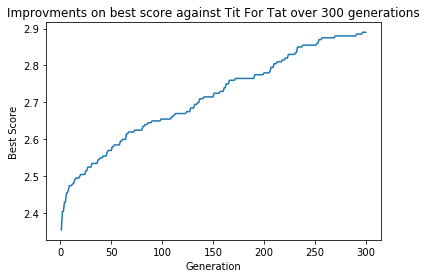

In [10]:
plt.plot(df_one["generation"],df_one["best_score"])
plt.title("Improvments on best score against Tit For Tat over 300 generations")
plt.xlabel("Generation")
plt.ylabel("Best Score")

What we want to look at is how the best score rises as we change certain features of the algorithm. Once the best score hits a maximum such that it _wont change no mater how many more generations are run_ (designated as an optimal solution sequence) or it hits a score which _dosen't change over a significant period of generations_ (solution sequence) we can say that the _sequence has converged_. The generation number where this plateau occours is called the __solution sequence distance__, or solution distence; mimising this is that aim of this investagation.

We may find solutions that are not optimal, meaning that the algorithem will narrow down a sequence that will do well against an opponent but wont actually find the best sequence that we can possibly get. These are called local maximums and we will look into how to overcome the possibility of our algorthem finding a local, rather than, global maximum later.

If we make each sequence   __more likly to mutate__ generation to generation what will happen? If we have a __larger initial population__ sample to start with, will we reach our maximum best score earlier? What about __increasing the generations__, what is the optimal number of generations to run the algorithm for such that we always find a solution sequence.

the selection of opponents for this section is such that we are able to know their optimal solution sequence as to idntify local maxium solution sequences.

# Initial Population Size
The initial population size defines the range of scores that we can achive against an opponent in any given generation. Because of this it is assumed the larger a population the larger chance of finding a solution sequence. This, however, will have an impact on computation time; each generation must process the full population, this is a linier relationship, $O(n)$, on computation so we would need to find a higher order of decrease in out solution distence for this to be a viable option.

The concept of population increase is simple, all we need to look for is the solution distance as we increase our population:

In [11]:
col_names = ["generation", "mean_score", "standard_deviation", "best_score", "sequence"]

In [12]:
populations = [25,50,100,150,200,250,500]

In [13]:
def populationChecker(opponent):
    # make a nice file name
    file_name = "data/" + str(opponent).replace(" ", "_").replace(":","_").lower() + "_pop.csv"

    # if the file exists dont run, it takes forever, make sure it exists 
    if not os.path.isfile(file_name):
        df_main = pd.DataFrame(data=None, columns=col_names)  
    
        for pop_size in populations:
            start_time = time.clock()
            pop_run = runGeneticAlgo(opponent,
                                 population_size=pop_size,
                                 number_of_game_turns=200,
                                 cycle_length=200, 
                                 generations=150,
                                 mutation_probability=0.1, 
                                 reset_file=True)
            end_time = time.clock()
            tmp_df = pd.read_csv(pop_run[0], names=col_names)
            tmp_df["population"] = pop_size
            tmp_df["time_taken"] = end_time-start_time
            df_main = df_main.append(tmp_df, ignore_index=True)
    
        df_main.to_csv(file_name)
        print("List Complete:",file_name)
        return df_main
    else:
        print("file already exists, no calcs to do.")
        file_df = pd.read_csv(file_name) 
        # remove first column
        file_df = file_df[list(file_df)[1:]]
        return file_df
        

In [146]:
df_TitForTat_pop = populationChecker(axl.TitForTat())
df_Alternator_pop = populationChecker(axl.Alternator())
df_Grudger_pop = populationChecker(axl.Grudger())
df_Random_pop = populationChecker(axl.Random())
df_Evolved_pop = populationChecker(axl.EvolvedFSM16())
df_Collective_pop = populationChecker(axl.CollectiveStrategy())

mutation_pop_dict = {"Tit For Tat":df_TitForTat_pop,
                    "Alternator":df_Alternator_pop,
                    "Grudger":df_Grudger_pop,
                    "Random":df_Random_pop,
                    "Evolved FSM16":df_Evolved_pop,
                    "Collective Stratergy":df_Collective_pop}

file already exists, no calcs to do.
file already exists, no calcs to do.
file already exists, no calcs to do.
file already exists, no calcs to do.
file already exists, no calcs to do.
file already exists, no calcs to do.


In [16]:
df_TitForTat_pop.groupby("population")["best_score"].describe()

,count,mean,std,min,25%,50%,75%,max
population,,,,,,,,
25.0,150.0,2.598933,0.093817,2.425,2.53000,2.5900,2.68250,2.765
50.0,150.0,2.687133,0.120228,2.395,2.58125,2.6975,2.80000,2.845
100.0,150.0,2.751500,0.120838,2.425,2.67000,2.7550,2.85875,2.925
150.0,150.0,2.766767,0.130739,2.445,2.65625,2.8000,2.88500,2.930
200.0,150.0,2.766000,0.137777,2.440,2.67000,2.8050,2.88375,2.940
250.0,150.0,2.759300,0.132872,2.420,2.66625,2.7850,2.86875,2.940
500.0,150.0,2.805033,0.128228,2.480,2.71625,2.8250,2.91500,2.980


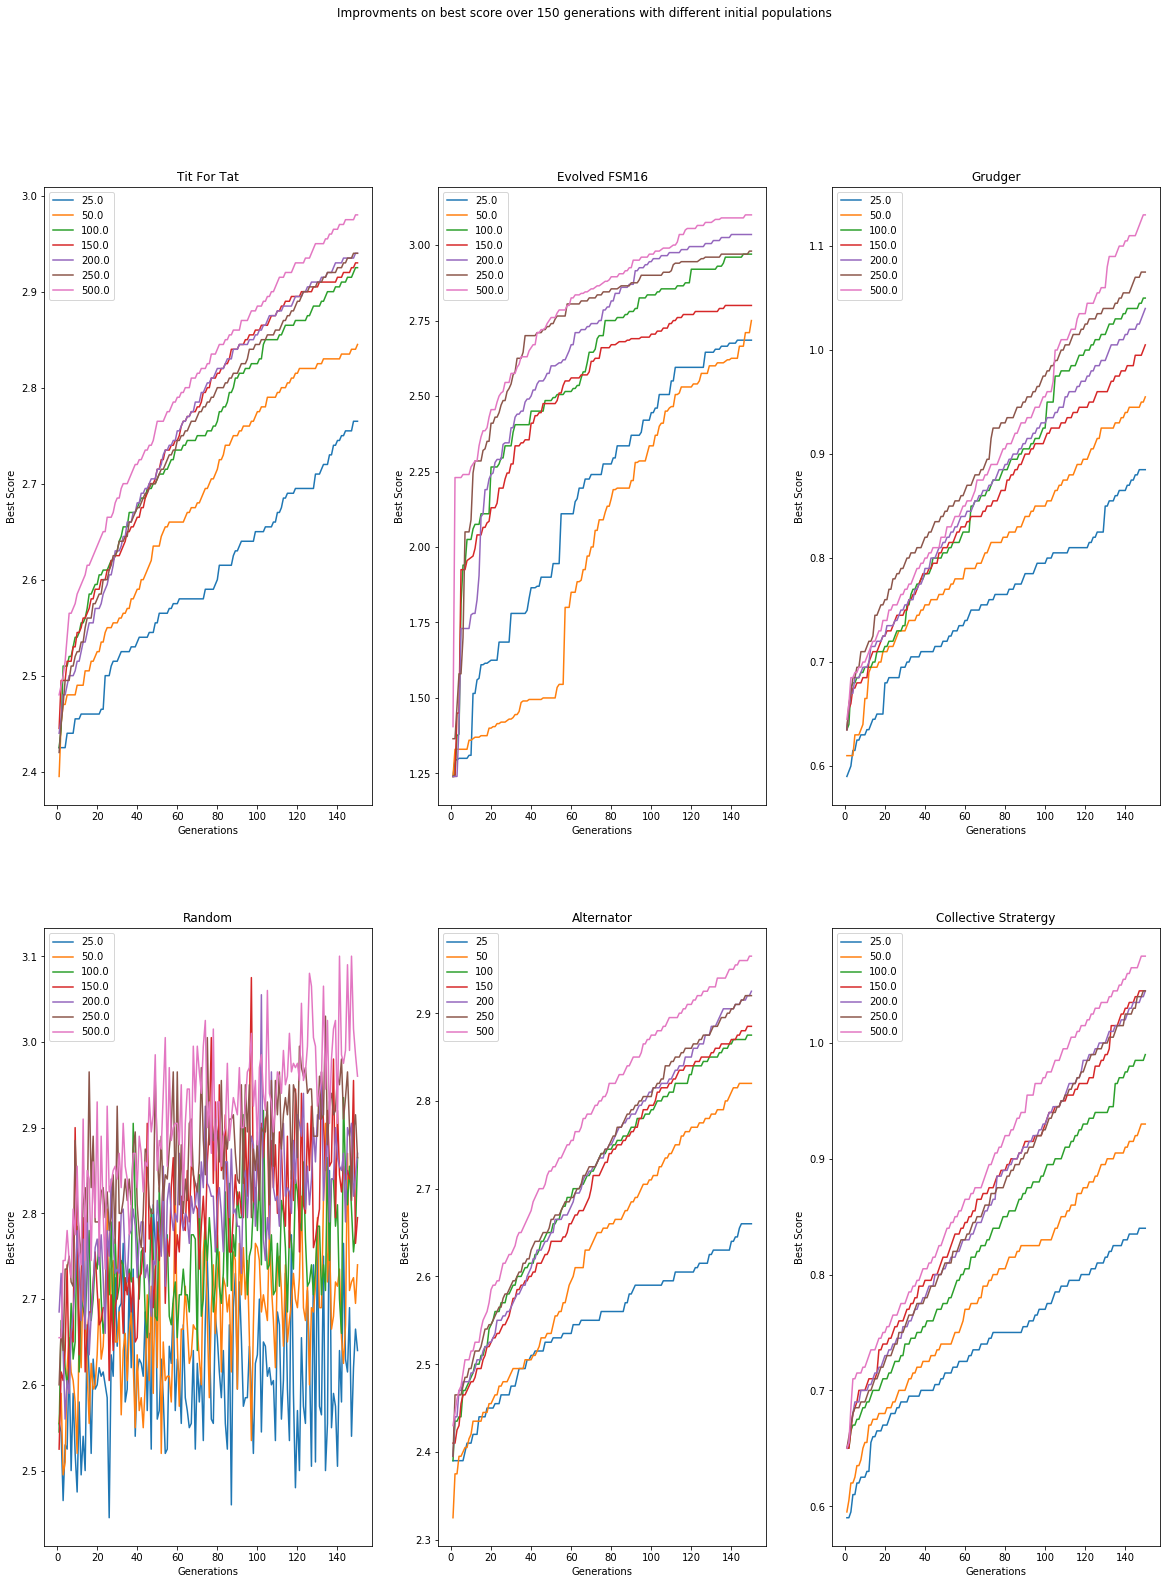

In [153]:
working_dict = mutation_pop_dict

f, axs = plt.subplots(2,3, sharex=False, figsize=(20,25))
f.suptitle("Improvments on best score over 150 generations with different initial populations")

a=0
for opponent in working_dict:
    axs[a%2,a%3].set_title(opponent)
    a+=1

i=0
for opponet in working_dict:
    for lab, df in working_dict.get(opponet).groupby("population"):
        axs[i%2,i%3].plot(df["generation"],df["best_score"], label=lab)
    i += 1

for j in range(len(working_dict)):
    axs[j%2,j%3].set(xlabel='Generations', ylabel='Best Score')
    axs[j%2,j%3].legend()


f.savefig('plots/initial_pop/ini_pop score all opponents.png')

Its clear that from the graph that the initial population size has a huge effect on finding the Tit For Tat solution sequence. It can also be seen from the table that as we increase the population our best score statistics go up across the board. Looking into alternator we will see the same.

In [17]:
df_alternator_pop = populationChecker(axl.Alternator())

file already exists, no calcs to do.


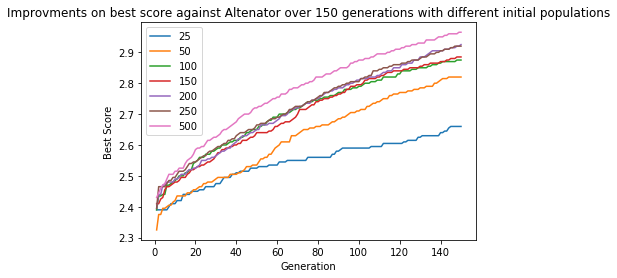

In [18]:
plt.title("Improvments on best score against Altenator over 150 generations with different initial populations")
plt.xlabel("Generation")
plt.ylabel("Best Score")

for pop_label, population_size_df in df_alternator_pop.groupby("population"):                       
    plt.plot(population_size_df["generation"],population_size_df["best_score"],label=pop_label)
    
plt.legend()

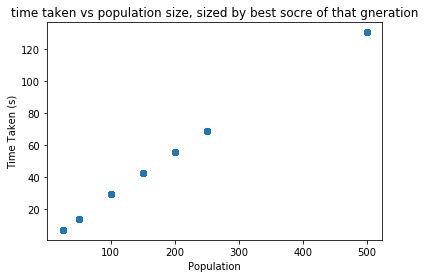

In [19]:
plt.title("time taken vs population size, sized by best socre of that gneration")
plt.xlabel("Population")
plt.ylabel("Time Taken (s)")

plt.scatter(df_alternator_pop["population"],df_alternator_pop["time_taken"])
# todo: weight each point by ave score

#### Analysis of results for Tit For Tat & Alternator
As the figures above shows there is an obvous trend that the higher the overall average score. What is intresting is that the result is non linier, the best score difference for a population of 50 to a population of 100 is huge in comparison to the same relative increas from 200 to 250.

Another intresting point is that none of these results have found a solution sequence (or at least we cant tell from the graph). There are no large plateaus for the graph, and so prehapse using a medium size population, say 150, and increasing the generations will have better results for a solution sequence. 150 is selected becuase there it find the same scoring solution as the others, but takes less time

In [20]:
df_random_pop = populationChecker(axl.Random())

file already exists, no calcs to do.


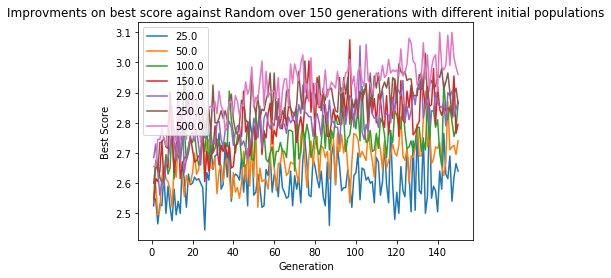

In [21]:
plt.title("Improvments on best score against Random over 150 generations with different initial populations")
plt.xlabel("Generation")
plt.ylabel("Best Score")

for pop_label, population_size_df in df_random_pop.groupby("population"):                       
    plt.plot(population_size_df["generation"],population_size_df["best_score"],label=pop_label)
    
plt.legend()

##### Random Analysis
This is intresting, the random results tend to fare better with larger population, this may just be based on the probability that there is a sequence in the population that does better against the specific random sequence. This may also be the genetic algorthem optomising itself to the psudorandom generator, building the "random" opponent solution for next generation, this could be a reason as all of the final generation best performers are scoring higher than the original starting population. 

check actual sequences generated. we should find [DDD...D]

## Generation Length Analysis
Here we will look into how close to a solution sequence we get when we increase the generations the algorithm runs for. We will be using a population of 150, as this was the best average for score vs computiation time

In [22]:
generation_list = [50,150,250,350,450,500]

In [23]:
def generationSizeChecker(opponent):
    file_name = "data/" + str(opponent).replace(" ", "_").replace(":","_").lower() + "_generation.csv"

    if not os.path.isfile(file_name):
        df_main = pd.DataFrame(data=None, columns=col_names)  
    
        for gens in generation_list:
            start_time = time.clock()
            pop_run = runGeneticAlgo(opponent,
                                 population_size=150,
                                 number_of_game_turns=200,
                                 cycle_length=200, 
                                 generations=gens,
                                 mutation_probability=0.1, 
                                 reset_file=True)
            end_time = time.clock()
            tmp_df = pd.read_csv(pop_run[0], names=col_names)
            tmp_df["generations"] = gens
            tmp_df["time_taken"] = end_time-start_time
            tmp_df["opponent"] = str(opponent)
            tmp_df["best_score_diff"] = np.append([0],np.diff(tmp_df["best_score"]))
            df_main = df_main.append(tmp_df, ignore_index=True)
        
        df_main.to_csv(file_name)
        print("List Complete:",file_name)
        return df_main
    else:
        print("file ",file_name," already exists, no calcs to do.")
        file_df = pd.read_csv(file_name) 
        # remove first column
        file_df = file_df[list(file_df)[1:]]
        return file_df

In [24]:
df_TitForTat_gen = generationSizeChecker(axl.TitForTat())

file  data/tit_for_tat_generation.csv  already exists, no calcs to do.


In [25]:
df_alternator_gen = generationSizeChecker(axl.Alternator())

file  data/alternator_generation.csv  already exists, no calcs to do.


In [26]:
df_grudger_gen = generationSizeChecker(axl.Grudger())

file  data/grudger_generation.csv  already exists, no calcs to do.


In [127]:
df_TitForTat_gen = generationSizeChecker(axl.TitForTat())
df_Alternator_gen = generationSizeChecker(axl.Alternator())
df_Grudger_gen = generationSizeChecker(axl.Grudger())
df_Random_gen = generationSizeChecker(axl.Random())
df_Evolved_gen = generationSizeChecker(axl.EvolvedFSM16())
df_Collective_gen = generationSizeChecker(axl.CollectiveStrategy())

mutation_gen_dict = {"Tit For Tat":df_TitForTat_gen,
                    "Alternator":df_Alternator_gen,
                    "Grudger":df_Grudger_gen,
                    "Random":df_Random_gen,
                    "Evolved FSM16":df_Evolved_gen,
                    "Collective Stratergy":df_Collective_gen}

file  data/tit_for_tat_generation.csv  already exists, no calcs to do.
file  data/alternator_generation.csv  already exists, no calcs to do.
file  data/grudger_generation.csv  already exists, no calcs to do.
file  data/random__0.5_generation.csv  already exists, no calcs to do.
file  data/evolved_fsm_16_generation.csv  already exists, no calcs to do.
file  data/collectivestrategy_generation.csv  already exists, no calcs to do.


In [28]:
df_TitForTat_gen.head()

,best_score,best_score_diff,generation,generations,mean_score,opponent,sequence,standard_deviation,time_taken
0,2.445,0.000,1,50.0,2.263033,Tit For Tat,"[C, C, D, C, C, C, C, D, C, C, C, C, C, D, C, ...",0.070675,13.871835
1,2.490,0.045,2,50.0,2.350265,Tit For Tat,"[C, C, C, C, C, D, C, C, C, C, D, D, C, D, C, ...",0.055142,13.871835
2,2.495,0.005,3,50.0,2.402765,Tit For Tat,"[C, C, C, C, C, D, C, C, C, C, D, D, C, D, C, ...",0.055686,13.871835
3,2.495,0.000,4,50.0,2.444318,Tit For Tat,"[C, C, C, C, C, D, C, C, C, C, D, D, C, D, C, ...",0.048382,13.871835
4,2.500,0.005,5,50.0,2.460265,Tit For Tat,"[C, D, D, C, C, C, C, D, C, C, C, D, C, C, D, ...",0.054711,13.871835


Generation size analysis is a bit different as we want to see what length of generation will provide us with the largest change in score from first iteration to last, but we dont want a huge calculation time. if we look at the scatter of __mean best score difference__ against the __number of generations__ we can observe how, on average, the number of generations effects the overall change in our best score.  

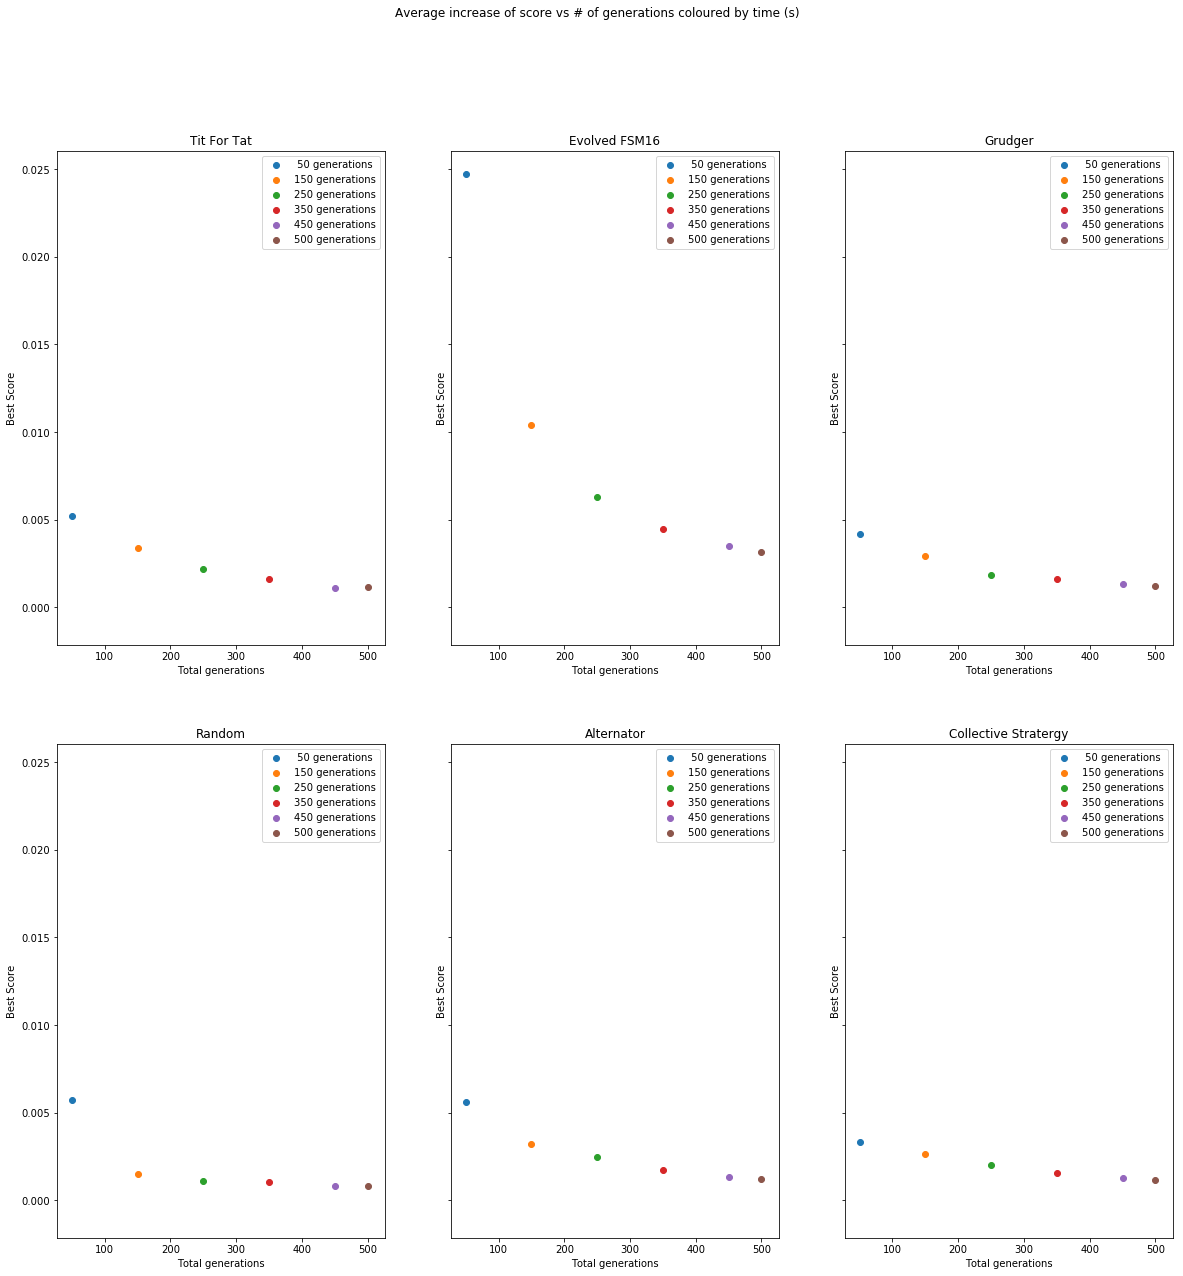

In [142]:
working_dict = mutation_gen_dict

f, axs = plt.subplots(2,3, sharex=False,sharey=True, figsize=(20,20))
f.suptitle("Average increase of score vs # of generations")

a=0
for opponent in working_dict:
    axs[a%2,a%3].set_title(opponent)
    a+=1

i=0
for opponet in working_dict:
    for lab, df in working_dict.get(opponet).groupby("generations"):
        axs[i%2,i%3].scatter(lab,df["best_score_diff"].mean(), label="{:3.0f} generations".format(lab))
    i+=1

for j in range(len(working_dict)):
    axs[j%2,j%3].set(xlabel='Total generations', ylabel='Best Score')
    axs[j%2,j%3].legend()


f.savefig('plots/gen_len/gen_len avg diff all opponents.png')

__^Average increase of score vs # of generations coloured by time (s)^__

This is is showing that for both Alternator and Tit For Tat opponents, the mean increase per generation is decling. On this result we can conclude as we increase generations there is less and less benifit per generation. From these plots i would suggest that running 150 generations has the best time vs mean best score increase per generation.

Now we can look at proximity the solution sequence once the analysis has concluded, this will provide details on what the solution looks like as we extend our generation length. obviosly we want to find the absolute soution sequence, if it exists, every time; the reason for looing at length is so that we can observe what the average number of generations is required to find the solution sequence.

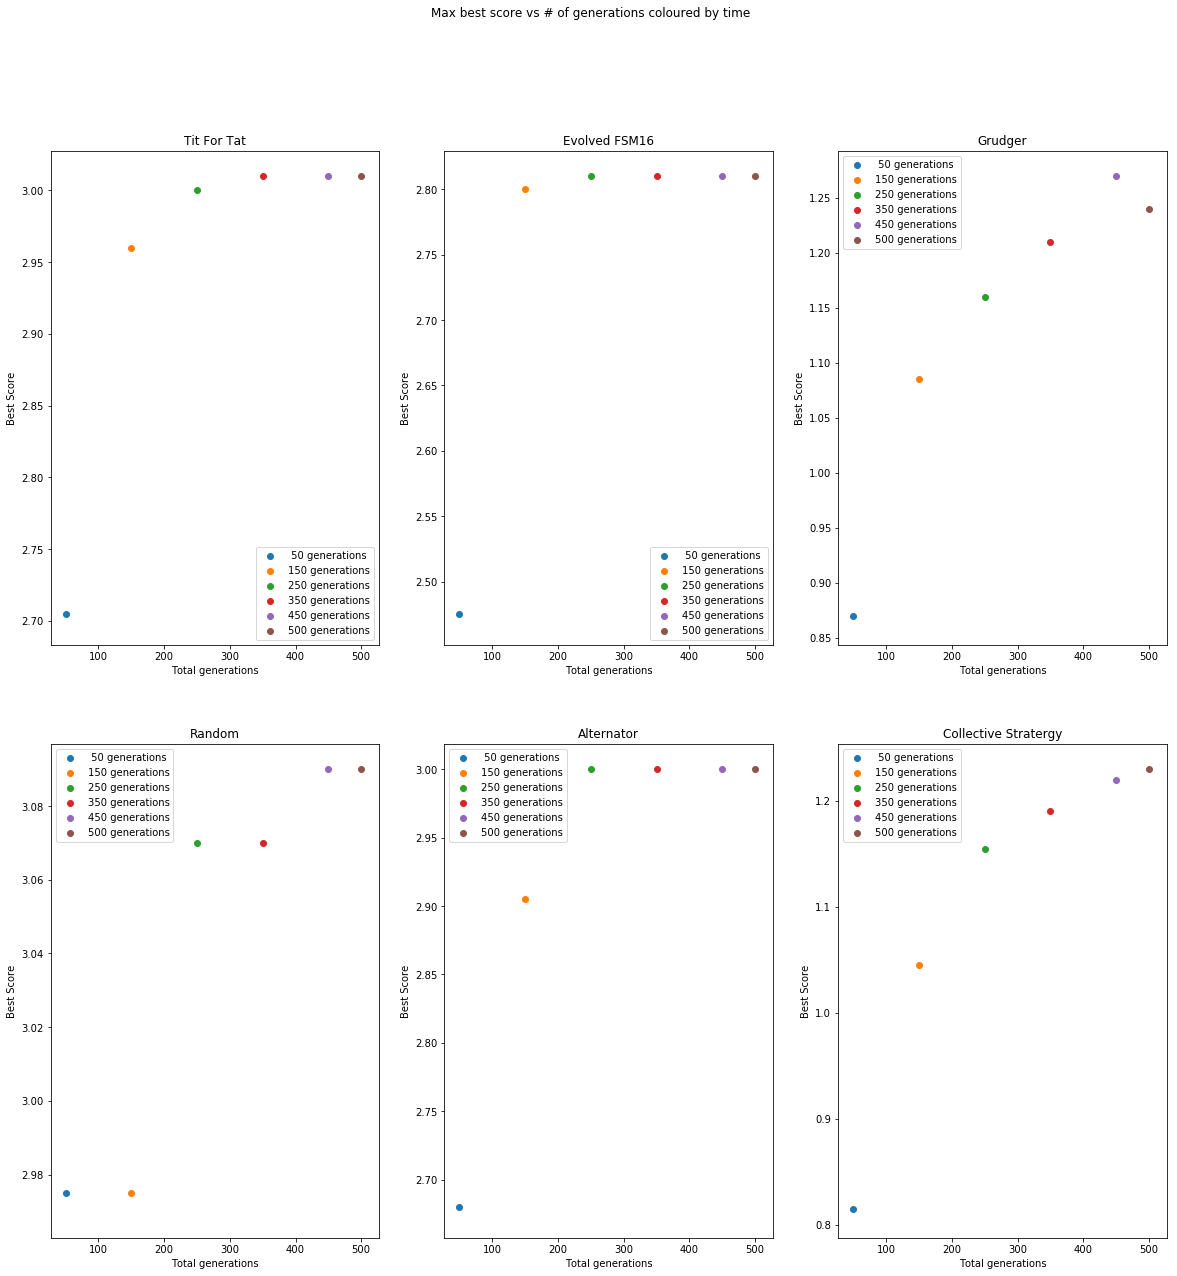

In [145]:
working_dict = mutation_gen_dict

f, axs = plt.subplots(2,3, sharex=False, figsize=(20,20))
f.suptitle("Max best score vs # of generations coloured by time")

a=0
for opponent in working_dict:
    axs[a%2,a%3].set_title(opponent)
    a+=1

i=0
for opponet in working_dict:
    for lab, df in working_dict.get(opponet).groupby("generations"):
        axs[i%2,i%3].scatter(lab,df["best_score"].max(), label="{:3.0f} generations".format(lab))
    i+=1

for j in range(len(working_dict)):
    axs[j%2,j%3].set(xlabel='Total generations', ylabel='Best Score')
    axs[j%2,j%3].legend()


f.savefig('plots/gen_len/gen_len best score all opponents.png')

__^Max best score vs # of generations coloured by time^__

After 250 generations we seem to have reached the solution state for our opponents Tit for tat and alernator but not for grudger. From the combination of the two plots, having more generations means that there is, on average, less of an improvment per generation but the longer analysis is required to find the solution sequence for an opponent. From now on, 250 is the number of generations we will use to find out solution sequence.

> quick note on __Grudger__ It appears that the grudger opponent is being optomised into becoming 2 sections of opposong moves. if we look at the start and end of a generation set we can see that the genetic algo is trying to remove Cs after the defect point and add Cs before the defect point. This solution is due to the fact a good solution will have found that ennding in lots off defections is good, and as it progressed there isnt a chance to observe an ending of coperations. This is a clear sign of the algorthem locating a local maximum, looking into the mutation rate might provide a reason why this is happening.

In [31]:
df_grudger_gen["sequence"][1250] 

'[C, C, C, C, C, C, D, D, D, D, D, D, D, D, C, C, D, C, C, D, C, C, C, C, C, C, D, C, C, D, D, C, C, C, C, D, D, C, D, C, C, D, D, D, D, D, D, D, D, D, D, C, D, C, D, D, D, C, D, D, D, C, D, C, D, C, C, D, D, C, D, C, D, D, C, C, C, D, D, D, D, D, C, C, D, D, C, C, D, C, D, D, C, D, C, C, C, C, D, C, C, D, C, D, C, C, D, D, D, C, D, C, C, D, D, C, D, D, D, D, D, D, D, C, C, C, D, D, C, D, D, C, C, C, D, C, D, D, D, D, D, C, D, C, D, C, D, C, D, C, D, C, C, C, C, D, C, D, C, D, D, D, D, C, C, D, C, D, D, D, C, D, C, C, D, D, D, C, C, C, C, D, C, D, D, D, C, C, D, D, D, D, C, C, D, C, C, D, D, D]'

In [32]:
df_grudger_gen["sequence"][1749] 

'[C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, C, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]'

For the most "simple" opponents 250 generations seems reasonable to reach a solution sequence as shown in the Alternor and Tit For Tat. The complexities lie with mitigating local maximums during the generations.

# Changeing Our Mutation Rate
By changing the rate at which we mutate our genes within a sequence, we might be able to more effectivly narrow in on a solution sequence, i.e. one that has converged. The default is set to 0.1, which means, for every 10 members of our population that continue into the next generation one of these has a single gene, or action, that is changed in its sequence. 

Here we will look at 2 different concepts:
* Is changing one or more action(s) of a members' sequence the best way of mutating a candiadte? (_More potent mutation_)
* Is it beneficial for more/less than 1 in 10 members to be mutated generation to generation? (_More frequent mutation_)

These are two seperate questions, so first we will look at increasing the potency of our mutation. Then, once we have found some information out on this, we can look into the frequency of our mutations whith the new potency as a perminant setting. This approach allows for an $O(1)$ factor of scaling making this a great candidate for an approach to reduce our solution sequence distance compared with other approaches, for example increasing the population size.

### Changing Mutation Potency

In [36]:
opponent_list = [axl.TitForTat(), axl.Alternator(), axl.Defector(), axl.Gradual(), axl.Cycler(cycle=my_cycler_Seq),axl.Random()]
mutation_potency_list = [1,2,3,5,10,15,20]

In [37]:
def mutationPotencyChecker(opponent):
    file_name = "data/" + str(opponent).replace(" ", "_").replace(":","_").lower() + "_mutation_potency.csv"

    if not os.path.isfile(file_name):
        df_main = pd.DataFrame(data=None, columns=col_names)  
    
        for potency in mutation_potency_list:
            start_time = time.clock()
            pot_run = runGeneticAlgo(opponent,
                                 population_size=150,
                                 number_of_game_turns=200,
                                 cycle_length=200, 
                                 generations=250,
                                 mutation_probability=0.1,
                                 mutation_potency=potency,
                                 reset_file=True)
            end_time = time.clock()
            tmp_df = pd.read_csv(pot_run[0], names=col_names)
            tmp_df["mutation_potency"] = potency
            tmp_df["time_taken"] = end_time-start_time
            tmp_df["opponent"] = str(opponent)
            tmp_df["best_score_diff"] = np.append([0],np.diff(tmp_df["best_score"]))
            df_main = df_main.append(tmp_df, ignore_index=True)
        
        df_main.to_csv(file_name)
        print("List Complete:",file_name)
        return df_main
    else:
        print("file ",file_name," already exists, no calcs to do.")
        file_df = pd.read_csv(file_name) 
        # remove first column
        file_df = file_df[list(file_df)[1:]]
        return file_df

In [114]:
df_TitForTat_potency = mutationPotencyChecker(axl.TitForTat())
df_Alternator_potency = mutationPotencyChecker(axl.Alternator())
df_Grudger_potency = mutationPotencyChecker(axl.Grudger())
df_Random_potency = mutationPotencyChecker(axl.Random())
df_Evolved_potency = mutationPotencyChecker(axl.EvolvedFSM16())
df_Collective_potency = mutationPotencyChecker(axl.CollectiveStrategy())

mutation_potency_dict = {"Tit For Tat":df_TitForTat_potency,
                    "Alternator":df_Alternator_potency,
                    "Grudger":df_Grudger_potency,
                    "Random":df_Random_potency,
                    "Evolved FSM16":df_Evolved_potency,
                    "Collective Stratergy":df_Collective_potency}

file  data/tit_for_tat_mutation_potency.csv  already exists, no calcs to do.
file  data/alternator_mutation_potency.csv  already exists, no calcs to do.
file  data/grudger_mutation_potency.csv  already exists, no calcs to do.
file  data/random__0.5_mutation_potency.csv  already exists, no calcs to do.
file  data/evolved_fsm_16_mutation_potency.csv  already exists, no calcs to do.
file  data/collectivestrategy_mutation_potency.csv  already exists, no calcs to do.


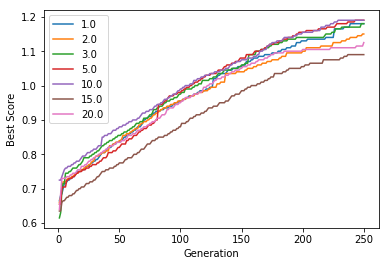

In [115]:
plt.xlabel("Generation")
plt.ylabel("Best Score")

for lab, df in df_Grudger_potency.groupby("mutation_potency"):
    plt.plot(df["generation"],df["best_score"], label=lab)
    
plt.legend()

This single graph shows no clear benifit from increasing the mutation potency. We can see that having changed 15 genes in our sequence eatcch time we are still not improving our score as much as using 1. This may be down to chance (and if the file is regenerated this may disapear) looking at more opponents than just grudger we may find a clear improvment.

Now we can look at how our best score is effected against other opponents.

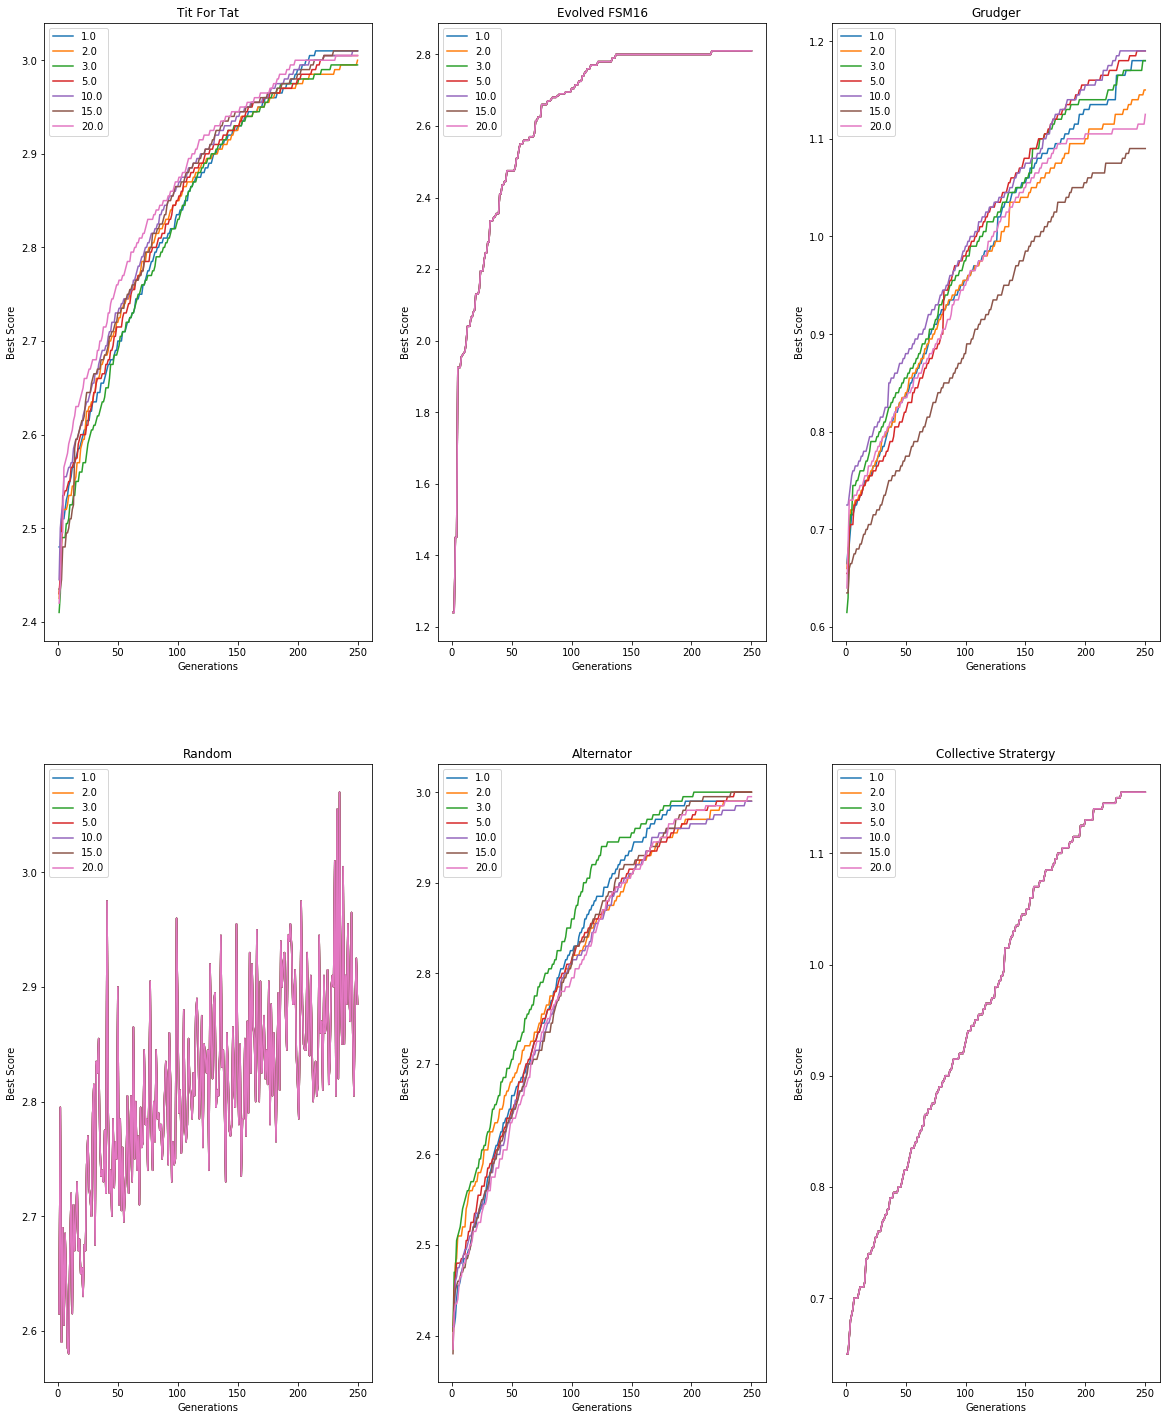

In [123]:
working_dict = mutation_potency_dict

f, axs = plt.subplots(2,3, sharex=False, figsize=(20,25))
f.suptitle("")

a=0
for opponent in working_dict:
    axs[a%2,a%3].set_title(opponent)
    a+=1

i=0
for opponet in working_dict:
    for lab, df in working_dict.get(opponet).groupby("mutation_potency"):
        axs[i%2,i%3].plot(df["generation"],df["best_score"], label=lab)
    i += 1

for j in range(len(working_dict)):
    axs[j%2,j%3].set(xlabel='Generations', ylabel='Best Score')
    axs[j%2,j%3].legend()


f.savefig('plots/mutation_pot/mut_pot all opponents.png')

__^Best score vs generations coloured by mutation potency^__

From these graphs there is no clear benifit to increasing the mutation potency to affect the overall __best score value__ against an opponent. If we insted look at what our __average increase of score per mutation__ is we may observe a useful result.

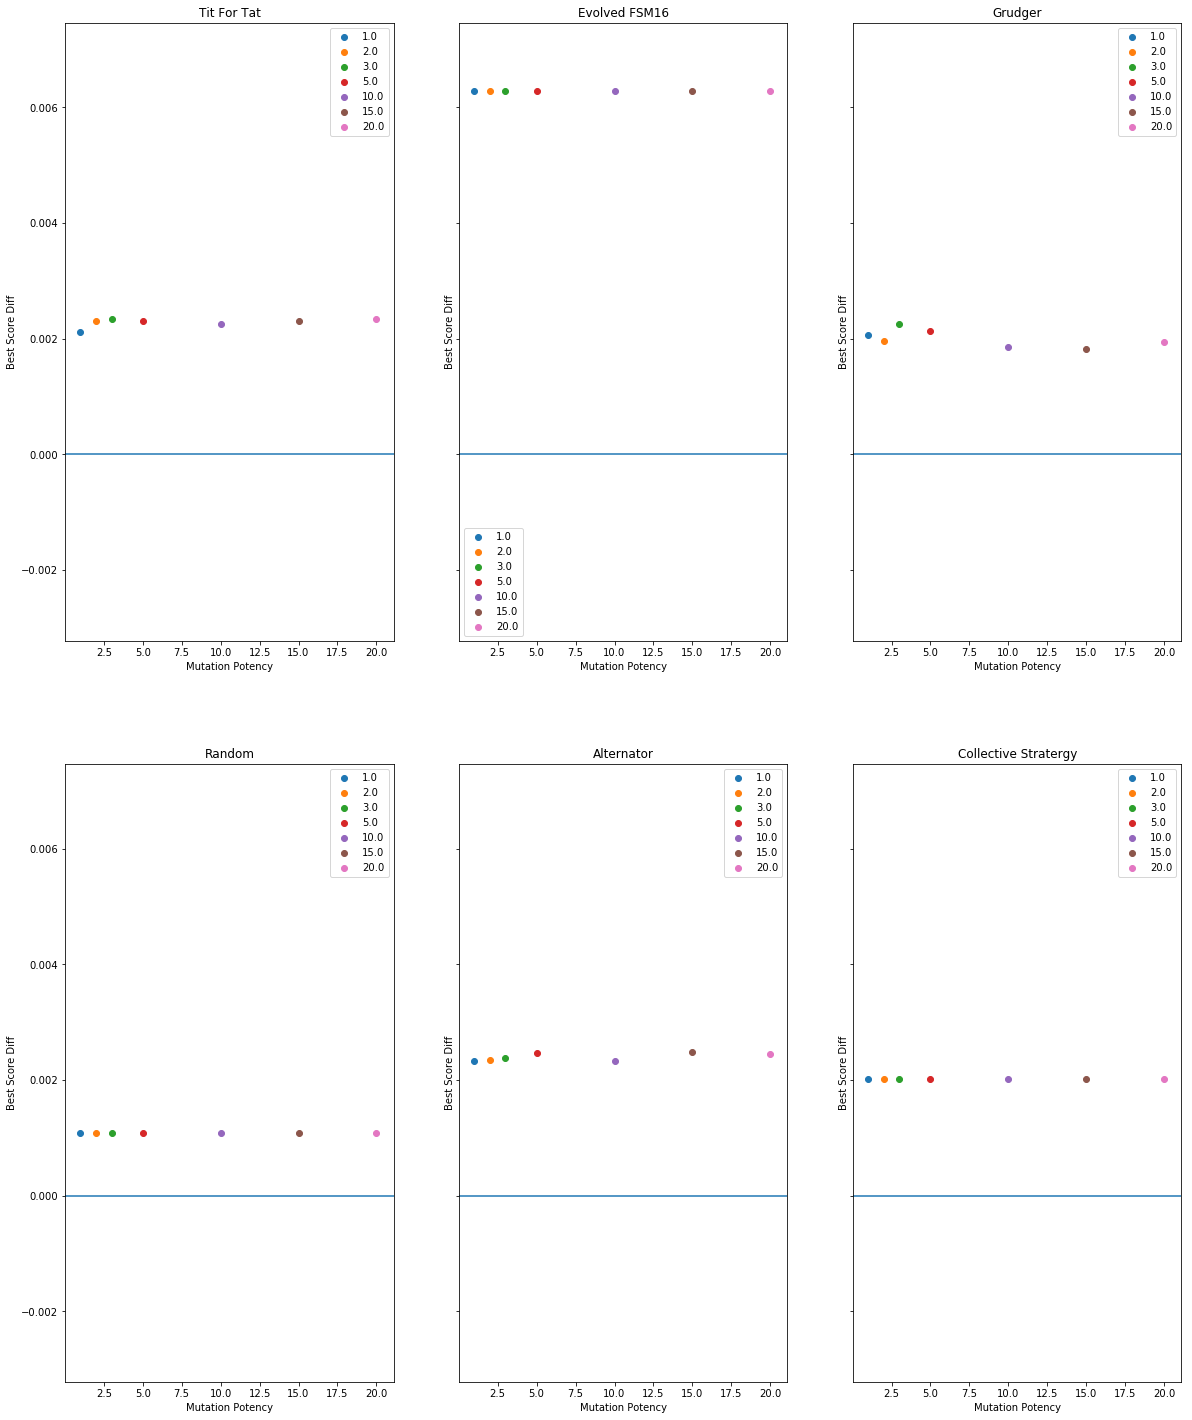

In [152]:
working_dict = mutation_potency_dict

f, axs = plt.subplots(2,3, sharex=False,sharey=True, figsize=(20,25))
f.suptitle("")

a=0
for opponent in working_dict:
    axs[a%2,a%3].set_title(opponent)
    a+=1

i=0
for opponet in working_dict:
    for lab, df in working_dict.get(opponet).groupby("mutation_potency"):
        axs[i%2,i%3].scatter(lab,df["best_score_diff"].mean(), label=lab)
    i += 1

for j in range(len(working_dict)):
    axs[j%2,j%3].set(xlabel='Mutation Potency', ylabel='Best Score Diff')
    axs[j%2,j%3].axhline(0)
    axs[j%2,j%3].legend()

f.savefig('plots/mutation_pot/mut_pot score diff all opponents.png')

(0, 0.003)

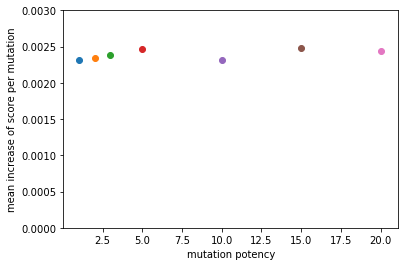

In [45]:
plt.xlabel("mutation potency")
plt.ylabel("mean increase of score per mutation")

for lab, df in df_Alternator_potency.groupby("mutation_potency"):
    plt.scatter(float(lab),df["best_score_diff"].mean())

plt.ylim(0,0.003)
    

In [ ]:
df_Alternator_potency.groupby("mutation_potency")["best_score"].describe()

In [ ]:
df_Alternator_potency.groupby("mutation_potency")["best_score_diff"].describe()

From further analysis there is not much of an improvment by increasing your mutation potency with regards to score or for average increase of score. The increase in mean best score difference is not substantial and could be down to chance(further anaysis needed, do some pvals and stuff? tho this is probs looking too much into it). 

### Changing Mutation Frequency

In [46]:
mutation_frequency_list = [0.1,0.15,0.2,0.25]

In [47]:
def mutationFrequencyChecker(opponent):
    file_name = "data/" + str(opponent).replace(" ", "_").replace(":","_").lower() + "_mutation_frequency.csv"

    if not os.path.isfile(file_name):
        df_main = pd.DataFrame(data=None, columns=col_names)  
    
        for freq in mutation_frequency_list:
            start_time = time.clock()
            pot_run = runGeneticAlgo(opponent,
                                 population_size=150,
                                 number_of_game_turns=200,
                                 cycle_length=200, 
                                 generations=250,
                                 mutation_probability=freq,
                                 mutation_potency=1,
                                 reset_file=True)
            end_time = time.clock()
            tmp_df = pd.read_csv(pot_run[0], names=col_names)
            tmp_df["mutation_frequency"] = freq
            tmp_df["time_taken"] = end_time-start_time
            tmp_df["opponent"] = str(opponent)
            tmp_df["best_score_diff"] = np.append([0],np.diff(tmp_df["best_score"]))
            df_main = df_main.append(tmp_df, ignore_index=True)
        
        df_main.to_csv(file_name)
        print("List Complete:",file_name)
        return df_main
    else:
        print("file ",file_name," already exists, no calcs to do.")
        file_df = pd.read_csv(file_name) 
        # remove first column
        file_df = file_df[list(file_df)[1:]]
        return file_df

In [80]:
df_TitForTat_freq = mutationFrequencyChecker(axl.TitForTat())
df_Alternator_freq = mutationFrequencyChecker(axl.Alternator())
df_Grudger_freq = mutationFrequencyChecker(axl.Grudger())
df_Random_freq = mutationFrequencyChecker(axl.Random())
df_Evolved_freq = mutationFrequencyChecker(axl.EvolvedFSM16())
df_Collective_freq = mutationFrequencyChecker(axl.CollectiveStrategy())

mutation_freq_dict = {"Tit For Tat":df_TitForTat_freq,
                    "Alternator":df_Alternator_freq,
                    "Grudger":df_Grudger_freq,
                    "Random":df_Random_freq,
                    "Evolved FSM16":df_Evolved_freq,
                    "Collective Stratergy":df_Collective_freq}

file  data/tit_for_tat_mutation_frequency.csv  already exists, no calcs to do.
file  data/alternator_mutation_frequency.csv  already exists, no calcs to do.
file  data/grudger_mutation_frequency.csv  already exists, no calcs to do.
file  data/random__0.5_mutation_frequency.csv  already exists, no calcs to do.
file  data/evolved_fsm_16_mutation_frequency.csv  already exists, no calcs to do.
file  data/collectivestrategy_mutation_frequency.csv  already exists, no calcs to do.


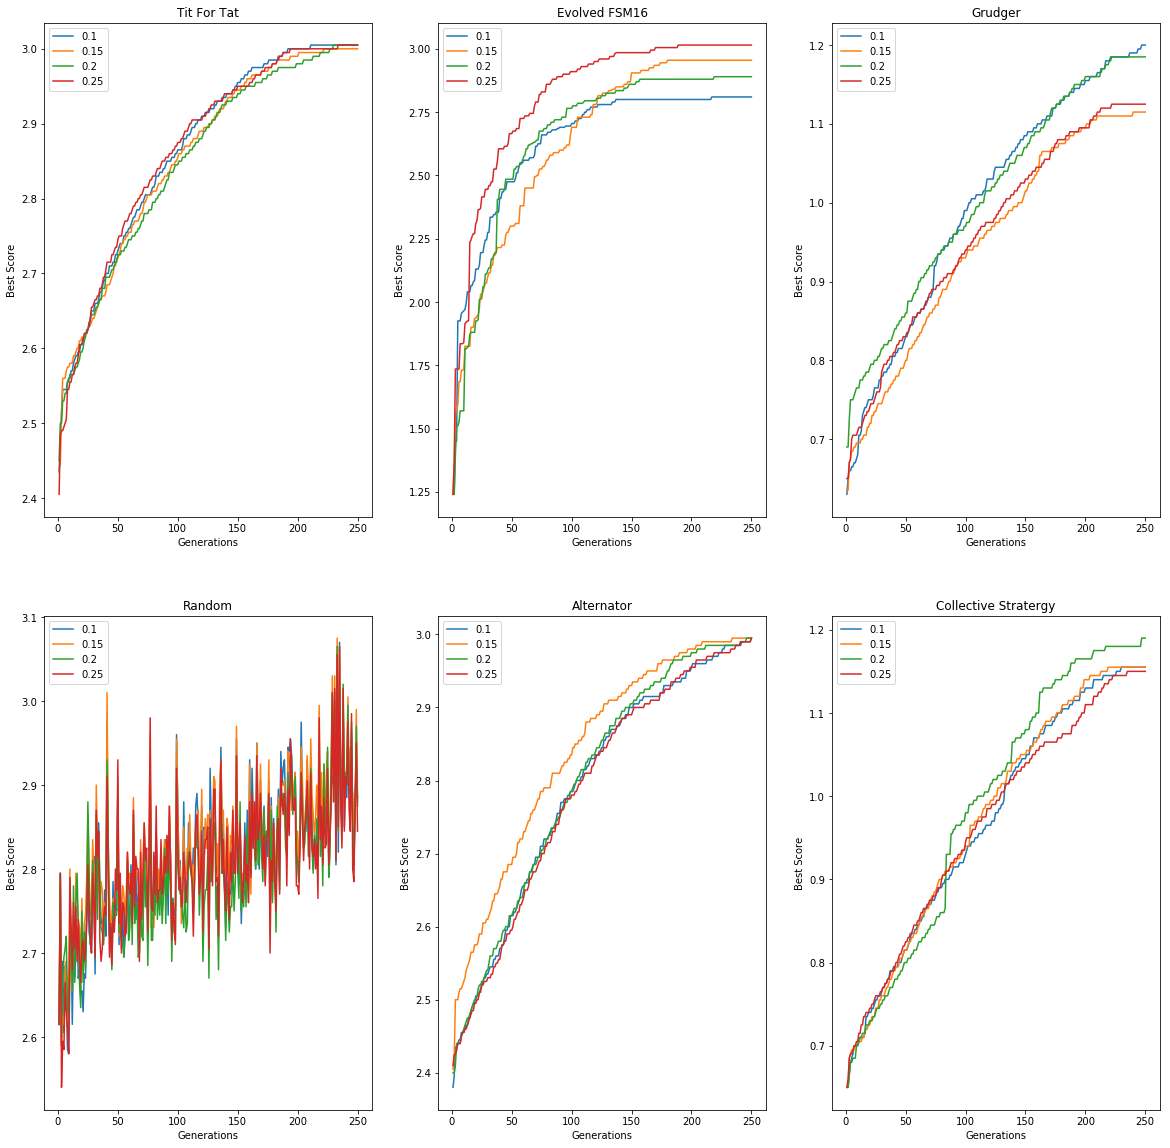

In [110]:
working_dict = mutation_freq_dict

f, axs = plt.subplots(2,3, sharex=False, figsize=(20,30))
f.suptitle("")

a=0
for opponent in working_dict:
    axs[a%2,a%3].set_title(opponent)
    a+=1

i=0
for opponet in working_dict:
    for lab, df in working_dict.get(opponet).groupby("mutation_frequency"):
        axs[i%2,i%3].plot(df["generation"],df["best_score"], label=lab)
    i += 1

for j in range(len(working_dict)):
    axs[j%2,j%3].set(xlabel='Generations', ylabel='Best Score')
    axs[j%2,j%3].legend()


f.savefig('plots/mutation_freq/mut_freq all opponents.png')

In [82]:
dicts = {"tit for tat": df_TitForTat_freq,
        "alternator": df_Alternator_freq}

# for l in dicts:
#     print(dicts.get(l).head())
    
print(len(dicts))

2


__^Graphs looking at best score vs generation, coloured by mutation freq.^__

The results on changing the mutaion rate dont obviously effect that generations until convergence from this overview. There is an intresting result that can be seen on the grudger plot; the algorthem has found 2 different maximums.  

In [ ]:
plt.title("Grudger")
plt.xlabel("Generations")
plt.ylabel("Best Score")

for lab, df in df_grudger_freq.groupby("mutation_frequency"):                       
    plt.plot(df["generation"],df["best_score"], label=lab)
                   
plt.legend()

In [ ]:
df_grudger_freq.groupby("mutation_frequency")["best_score"].describe()

from this there we can see that the mutation frequency of 0.1 & 0.2 produced higher scoring soutions than the other mutation frequencys. This shows that we have found 3 different solution sequences (in freqs .15, .2, .25) with the solution for .1 continuing to improve as the generations ended.

As an additional poin, we can also observe that increaseing the mutaton frequency means that there is less variation in the best scoring sequences. (Does this have an impact on escapint local maximums?) 

In [ ]:
plt.xlabel("Mutation freq.")
plt.ylabel("standard deviation of best score across generations")

for lab, df in df_grudger_freq.groupby("mutation_frequency"):
    plt.scatter(lab,df["best_score"].std(), label=lab)
    
plt.legend()

#### Changing mutation rates individualy analysis

Changing mutation frequency and mutation potency independantly had negligable effects with regard to a change of distance to convergence. It also seems to have neglible effects on the average increase of score per generation. ...CONTINUE SOMTHING

#### Using crossover & mutation to remove local maximum solutions 

The occourance of local maximums is something that has only occoured for the Grudger opponent so far. The difference between the Grudger and the other opponents were looking at is that the Grudger has a singularity where its behaviour changes. The change in behavour is not uncommon, Tit For Tat works in the same way, however this algorthem has managed to identify its behaviour and adapt to overcome its negative effects. 

Grudger and Tit For Tat differ in their responsivness in two ways: 
1) Grudger never changes its mind. There is __one change in behavior__ for the entire game. Unlike Tit For Tat, this means that the algorthem only has a single opertunity to observe this once every per population per generaton meaning the behaviour is much less frequently observed. 
2) The Grudger also only does this change once __no matter the games length__. This means that the genetic algorthem picks up  the effect of this choice as early in the match as the first defection in its random sequence. A random start of  C&Ds, puts the liklyhood of at least 1 defection occouring in the first 10 moves at 99.99%; this means our algorthem will, most likley, always encounter this grudging effect within the first 10 moves and will never score the full 600 points. (see below) 

Below are two totalilty games, one of all Cs and one of all Ds. These are edge cases and would be incredibly rarly encountered as a starting point in the initial population. Because of this the algorthem has to shuffle towards the potential benifit of using these totalities rather than start with analysing them, and in our case the algorthem will probably first encounter the Grudging effect of out opponent before trying out [CCC..C] or [CCC..D] and so will probably never find the highest scoring solition.


In [ ]:
players = (axl.Grudger(),axl.Cycler("C"))
match = axl.Match(players,200)
match.play()
print(match.final_score())
print(match.final_score_per_turn())

In [ ]:
players = (axl.Grudger(),axl.Cycler("D"))
match = axl.Match(players,200)
match.play()
print(match.final_score())
print(match.final_score_per_turn())

Strangly, our solution sequence is set to find where we have the objective of "score" (see objective statment) which actually tries to improve the score per turn (axelrod_dojo/utils.py:67); it should be converging on a totality of Cs rather than what its doing by finding the totality of Ds. This is probably because the algorthem initialy limits its _best score per turn_ once the first generation is complete and a cutoff has been espablished for each of the initial population. The crossover method between generations then dosent provide enough of a mix up to allow the algorthem to escape the local minimum by switching a subsection with a sufficiently different potentially better subsection. Then when it comes to mutating, there is little any number of mutations can do to drasticly change large sections of the sequence without having a huge effect on the score.

This then sheds light on the path the algorthem takes to find a solution. If we are to find the optimal solution, we must take a crossover & mutation path which dosent cut off better paths as we work our way towards a solution; this is much easier said than put into practice due to the way the algorthem "cuts off paths". 

If we reverse this thinking and try to alter our crossover design & mutation rate such that insted of "cutting off" a path we are able to "build" new ones. We can re-design the crossover to switch up large subsections of the sequence then allow the mutations to optamise these subsequences.

currently we have the following design:

In [ ]:
def crossover_old(self, other_cycler):
        # boring single point crossover:
        crossover_point = int(self.get_sequence_length() // 2)
        # get half 1 from self
        seq_p1 = self.get_sequence()[0: crossover_point]
        # get half 2 from the other_cycler
        seq_p2 = other_cycler.get_sequence()[crossover_point: other_cycler.get_sequence_length()]
        crossed_sequence = seq_p1 + seq_p2
        return CyclerParams(sequence=crossed_sequence)

We want to allow the crossover to have more of an impact than just halving the sequence and optamizing each section. i.e. go from:

|--------------------| & |++++++++++++++++++++| = |----------++++++++++|

to, say:

|--------------------| & |++++++++++++++++++++| = |--++--++--++--++--++|

This will allow the mutation rate to edit the subsections in a more interlaced manner, hopefully overcoming the pitfalls of sparce mutations to escape local maximums. our new crossover method is as follows:

In [ ]:
def crossover(self, other_cycler):
    # 10 crossover points:
    step_size = int(len(self.get_sequence()) / 10)
    
    # empty starting seq
    new_seq = []
    seq1 = self.get_sequence()
    seq2 = other_cycler.get_sequence()

    i = 0
    j = i + step_size

    while j <= len(seq1) - step_size:
        new_seq = new_seq + seq1[i:j]
        new_seq = new_seq + seq2[i + step_size:j + step_size]
        i += 2 * +step_size
        j += 2 * +step_size
        
    return CyclerParams(sequence=new_seq)

Below is an exapmple of the new crossover sequence

In [ ]:
seq1=[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
seq2=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

step_size =int(len(seq1)/10)

i=0
j=i+step_size
new_seq = []

while j<=len(seq1)-step_size:
    new_seq = new_seq + seq1[i:j]
    new_seq = new_seq + seq2[i+step_size:j+step_size]
    i+=2*+step_size
    j+=2*+step_size
    
print(seq1)
print(seq2)
print(new_seq)

now we can look at how this new crossover algorthem works with the default mutation (freq=.1 & pot=1) to improve our local maximums with the grudger opponent:

In [ ]:
df_grudger_multi = pd.DataFrame(data=None, columns=col_names+["run"])

for run in range(4):
    print(run+1)
    file_name, opponent_name = runGeneticAlgo(axl.Grudger())
    tmp_df = pd.read_csv(file_name, names=col_names)
    tmp_df["run"] = run+1
    df_grudger_multi = df_grudger_multi.append(tmp_df, ignore_index=True)

df_grudger_multi.to_csv("data/grudger_multi.csv")

In [ ]:
df_grudger_multi.groupby("run")["best_score"].describe()

For some reason were still looking movin towards an avg of 1.2ish on max best score, will look into it more.

## Conclusion
We changed: 
 * initial population
 * generation lenght
 * mutation frequency & potency
 
